# LSTM 

## Outline
1. [Imports](#imports)
2. [Data](#data)
3. [Model](#model)
5. [Train](#train)
6. [Predict](#predict)

<a name=imports></a>
## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

import preprocessing

<a name=data></a>
## Data

### Ingestion
Load in the dataset as pandas dataframe.

In [2]:
# Check preprocessing.py for implementation
(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df) = preprocessing.ingestion()

Parent Directory /covid19-prediction/models
Path: /covid19-prediction/models/../cleaned_datasets/india/daily_cases_india.csv
Exists: True
India Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-01-30        NaN     NaN        NaN
1  2020-01-31        0.0     0.0        0.0
2  2020-02-01        0.0     0.0        0.0
3  2020-02-02        1.0     0.0        0.0
4  2020-02-03        1.0     0.0        0.0 

India Vacc:
          Date  Total_Doses
0  2021-01-15          NaN
1  2021-01-16          NaN
2  2021-01-17      33120.0
3  2021-01-18     229748.0
4  2021-01-19     220786.0 

USA Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-04-12        NaN     NaN        NaN
1  2020-04-13    25255.0  1542.0    11785.0
2  2020-04-14    26694.0  2327.0     6484.0
3  2020-04-15    29318.0  2474.0     6093.0
4  2020-04-16    31235.0  4607.0     5234.0 

USA Vacc:
          Date  Total_Doses
0  2020-12-20          NaN
1  2020-12-21      57909.0
2  2020-12-22     196954.0
3  2020-

### Pre-Processing
Filter out unnecessary columns. 

#### Multivariate

In [3]:
# Check preprocessing.py for implementation
# Number of Null in India - 563
# Number of Null in USA - 261
(india_multi, usa_multi) = preprocessing.multivariate(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df)

India:
          Date  Confirmed  Total_Doses
0  2020-01-30        NaN          NaN
1  2020-01-31        0.0          NaN
2  2020-02-01        0.0          NaN
3  2020-02-02        1.0          NaN
4  2020-02-03        1.0          NaN
USA:
          Date  Confirmed  Total_Doses
0  2020-04-12        NaN          NaN
1  2020-04-13    25255.0          NaN
2  2020-04-14    26694.0          NaN
3  2020-04-15    29318.0          NaN
4  2020-04-16    31235.0          NaN


#### Univariate 

In [4]:
# Check preprocessing.py for implementation
# Number of Null in India - 0
# Number of Null in USA - 0
(india_cases_uni, usa_cases_uni) = preprocessing.univariate(india_cases_df, usa_cases_df)

India Cases:
    Confirmed
1        0.0
2        0.0
3        1.0
4        1.0
5        0.0 

USA Cases:
    Confirmed
1    25255.0
2    26694.0
3    29318.0
4    31235.0
5    32175.0 



### Drop Null
Merging the vaccination and #cases datasets together for multivariate time series produces null values. Dropping the nuWe solve this by dropping the null values.ll values ensures that we take an inner join.

In [5]:
(india_multi, usa_multi) = preprocessing.dropNull(india_multi, usa_multi)

India:
            Date  Confirmed  Total_Doses
353  2021-01-17    13788.0      33120.0
354  2021-01-18    10050.0     229748.0
355  2021-01-19    13816.0     220786.0
356  2021-01-20    15244.0     131649.0
357  2021-01-21    14545.0     237050.0
USA:
            Date  Confirmed  Total_Doses
253  2020-12-21   189716.0      57909.0
254  2020-12-22   201947.0     196954.0
255  2020-12-23   225777.0     196954.0
256  2020-12-24   204900.0     468280.0
257  2020-12-25   108685.0     234140.0


### Normalize
Perform a Z-score normalization.

In [6]:
# Check preprocessing.py for implementation
(india_uni_norm, usa_uni_norm, india_multi_norm, usa_multi_norm,india_cases_mean,india_cases_std,usa_cases_mean,usa_cases_std,india_multi_mean,india_multi_std,
usa_multi_mean, usa_multi_std) = preprocessing.normalize(india_cases_uni, 
                                                                                           usa_cases_uni, 
                                                                                           india_multi, 
                                                                                           usa_multi)

India Cases univariate:
    Confirmed
1  -0.662416
2  -0.662416
3  -0.662403
4  -0.662403
5  -0.662416 

USA Cases univariate:
    Confirmed
1  -0.596456
2  -0.584433
3  -0.562508
4  -0.546491
5  -0.538637 

India Cases multivariate:
      Confirmed  Total_Doses
353  -0.564210    -1.306870
354  -0.602772    -1.247747
355  -0.563921    -1.250442
356  -0.549190    -1.277244
357  -0.556401    -1.245551 

USA Cases multivariate:
      Confirmed  Total_Doses
253   0.524077    -0.977570
254   0.609261    -0.926634
255   0.775228    -0.926634
256   0.629828    -0.827240
257  -0.040273    -0.913012 



### Create Splits
Break the dataset into train and test. The current split is 80:20.

In [7]:
# Create train test splits
(india_uni_train, india_uni_test, usa_uni_train, usa_uni_test) = preprocessing.split(india_uni_norm, usa_uni_norm, 0.2)
(india_multi_train, india_multi_test, 
 usa_multi_train, usa_multi_test) = preprocessing.split(india_multi_norm, usa_multi_norm, 0.2)

India:
      Confirmed
1    -0.662416
2    -0.662416
3    -0.662403
4    -0.662403
5    -0.662416
..         ...
564  -0.332037
565  -0.200599
566  -0.184543
567  -0.182312
568  -0.210064

[568 rows x 1 columns] 

USA:
      Confirmed
1    -0.596456
2    -0.584433
3    -0.562508
4    -0.546491
5    -0.538637
..         ...
507   0.882933
508   0.655423
509   1.161010
510  -0.188293
511  -0.412010

[511 rows x 1 columns] 

India:
      Confirmed  Total_Doses
353  -0.564210    -1.306870
354  -0.602772    -1.247747
355  -0.563921    -1.250442
356  -0.549190    -1.277244
357  -0.556401    -1.245551
..         ...          ...
637  -0.558433     0.454255
638  -0.558794     1.464557
639  -0.574093     0.722069
640  -0.577353    -0.071408
641  -0.598924     0.193515

[278 rows x 2 columns] 

USA:
      Confirmed  Total_Doses
253   0.524077    -0.977570
254   0.609261    -0.926634
255   0.775228    -0.926634
256   0.629828    -0.827240
257  -0.040273    -0.913012
..         ...          ...
55

### Data Transformation
Simple conversion from pandas dataframe to numpy array by extracting the values.

In [8]:
# Univariate
india_uni_train_np, india_uni_test_np = india_uni_train.values,  india_uni_test.values
usa_uni_train_np, usa_uni_test_np = usa_uni_train.values, usa_uni_test.values
# Multivariate
india_multi_train_np, india_multi_test_np = india_multi_train.values,  india_multi_test.values
usa_multi_train_np, usa_multi_test_np = usa_multi_train.values, usa_multi_test.values

In [9]:
print(india_uni_train_np.shape, india_uni_test_np.shape)
print(india_multi_train_np.shape, india_multi_test_np.shape)

(568, 1) (143, 1)
(278, 2) (70, 2)


### Reshape
Converts the exiting train data set to match the input parameters of an LSTM (Samples, Time Steps, Features). The `lstm_data_transform()` method takes in 3 arguments: X data, y data and number of features.

We will be performing autoregression on the univariate data, therefore the X and y values are the same. As for the multivariate data, we will be using the confirmed column (index 0) as the y value.

In [10]:
india_uni_train_np

array([[-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62403204e-01],
       [-6.62403204e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62390076e-01],
       [-6.62416332e-01],
       [-6.62114388e-01],
       [-6.62390076e-01],
       [-6.62403204e-01],
       [-6.62376948e-01],
       [-6.62350692e-01],
       [-6.6

In [11]:
timesteps = 14

In [12]:
# Univariate
india_uni_train_X, india_uni_train_y = preprocessing.lstm_data_transform(india_uni_train_np, india_uni_train_np,
                                                                         timesteps)
usa_uni_train_X, usa_uni_train_y = preprocessing.lstm_data_transform(usa_uni_train_np, usa_uni_train_np,
                                                                     timesteps)
# Multivariate
india_multi_train_X, india_multi_train_y = preprocessing.lstm_data_transform(india_multi_train_np, india_multi_train_np, timesteps)
usa_multi_train_X, usa_multi_train_y = preprocessing.lstm_data_transform(usa_multi_train_np, usa_multi_train_np, timesteps)
# usa_multi_train_X, usa_multi_train_y = preprocessing.lstm_data_transform(usa_multi_train_np, usa_multi_train_np[:,0], timesteps)

In [13]:
print("Univariate India shape:",india_uni_train_X.shape, india_uni_train_y.shape)
print("Multivariate India shape:",india_multi_train_X.shape, india_multi_train_y.shape)

Univariate India shape: (554, 14, 1) (554, 1)
Multivariate India shape: (264, 14, 2) (264, 2)


The univariate array shape for the India dataset has 566 samples, 3 as the time step, and 1 feature for the X values. The y values is just the 566 samples.

Similarly, the multivariate array shape for the India dataset has 276 samples, 3 as the time step, and 2 features for the X values. The y values is just the 276 samples of the 0th column (Confirmed cases).

<a name=model></a>
## Model
We will define 4 models in total. One for the univariate data and another for the multivariate for each country.

In [14]:
import LSTMmodels
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

In [15]:
univariate_model_ind = LSTMmodels.build_lstm(time_steps=india_uni_train_X.shape[1],
                                             features=india_uni_train_X.shape[2])
univariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_uni_train_X.shape[1],
                                             features=usa_uni_train_X.shape[2])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
______________________________

In [16]:
multivariate_model_ind = LSTMmodels.build_lstm(time_steps=india_multi_train_X.shape[1],
                                               features=india_multi_train_X.shape[2], outputs=2)
multivariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_multi_train_X.shape[1],
                                               features=usa_multi_train_X.shape[2], outputs=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 43,262
Trainable params: 43,262
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2020      
____________________________

<a name=train></a>
## Train 

In [17]:
# Get the path of the current working directory
curPath = os.getcwd()
# Appened the parent directory to the current path to step out of the current folder
parentDir = os.path.abspath(os.path.join(curPath, os.pardir))
# Tensorboard callback
logdir = os.path.join(parentDir+"/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [18]:
def train_models(model,train_X,train_y,test_X,test_y):
    model.fit(train_X,train_y,
              validation_data=(test_X,test_y),
              epochs=300,
              callbacks=[tensorboard_callback])
    return model
#     model.save(save_name)

In [19]:
# Train the model on univariate India dataset 
univariate_model_ind = LSTMmodels.train_model(univariate_model_ind,india_uni_train_X,india_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
18/18 [==============================] - 2s 32ms/step - loss: 0.4840 - mae: 0.4840
Epoch 2/300
18/18 [==============================] - 0s 13ms/step - loss: 0.2313 - mae: 0.2313
Epoch 3/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1451 - mae: 0.1451
Epoch 4/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1213 - mae: 0.1213
Epoch 5/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1040 - mae: 0.1040
Epoch 6/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1086 - mae: 0.1086
Epoch 7/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0918 - mae: 0.0918
Epoch 8/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0796 - mae: 0.0796
Epoch 9/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0773 - mae: 0.0773
Epoch 10/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0897 - mae: 0.0897
Epoch 11/300
18/18 [=============================

18/18 [==============================] - 0s 13ms/step - loss: 0.0536 - mae: 0.0536
Epoch 87/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0521 - mae: 0.0521
Epoch 88/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0530 - mae: 0.0530
Epoch 89/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0537 - mae: 0.0537
Epoch 90/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0538 - mae: 0.0538
Epoch 91/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0520 - mae: 0.0520
Epoch 92/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0550 - mae: 0.0550
Epoch 93/300
18/18 [==============================] - 0s 14ms/step - loss: 0.0548 - mae: 0.0548
Epoch 94/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0504 - mae: 0.0504
Epoch 95/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0502 - mae: 0.0502
Epoch 96/300
18/18 [==============================] -

18/18 [==============================] - 0s 13ms/step - loss: 0.0460 - mae: 0.0460
Epoch 171/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0446 - mae: 0.0446
Epoch 172/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0440 - mae: 0.0440
Epoch 173/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0456 - mae: 0.0456
Epoch 174/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0446 - mae: 0.0446
Epoch 175/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0446 - mae: 0.0446
Epoch 176/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0450 - mae: 0.0450
Epoch 177/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0443 - mae: 0.0443
Epoch 178/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0447 - mae: 0.0447
Epoch 179/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0441 - mae: 0.0441
Epoch 180/300
18/18 [=======================

18/18 [==============================] - 0s 13ms/step - loss: 0.0516 - mae: 0.0516
Epoch 255/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0461 - mae: 0.0461
Epoch 256/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0398 - mae: 0.0398
Epoch 257/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0397 - mae: 0.0397
Epoch 258/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0439 - mae: 0.0439
Epoch 259/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0422 - mae: 0.0422
Epoch 260/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0408 - mae: 0.0408
Epoch 261/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0396 - mae: 0.0396
Epoch 262/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0386 - mae: 0.0386
Epoch 263/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0425 - mae: 0.0425
Epoch 264/300
18/18 [=======================

In [20]:
# Train the model on univariate USA dataset 
univariate_model_usa = LSTMmodels.train_model(univariate_model_usa,usa_uni_train_X,usa_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
16/16 [==============================] - 1s 32ms/step - loss: 0.3822 - mae: 0.3822
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1711 - mae: 0.1711
Epoch 3/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1465 - mae: 0.1465
Epoch 4/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1431 - mae: 0.1431
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1396 - mae: 0.1396
Epoch 6/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1345 - mae: 0.1345
Epoch 7/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1339 - mae: 0.1339
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1323 - mae: 0.1323
Epoch 9/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1308 - mae: 0.1308
Epoch 10/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1328 - mae: 0.1328
Epoch 11/300
16/16 [=============================

16/16 [==============================] - 0s 12ms/step - loss: 0.0796 - mae: 0.0796
Epoch 87/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0747 - mae: 0.0747
Epoch 88/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0779 - mae: 0.0779
Epoch 89/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0752 - mae: 0.0752
Epoch 90/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0714 - mae: 0.0714
Epoch 91/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0743 - mae: 0.0743
Epoch 92/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0736 - mae: 0.0736
Epoch 93/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0770 - mae: 0.0770
Epoch 94/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0750 - mae: 0.0750
Epoch 95/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0692 - mae: 0.0692
Epoch 96/300
16/16 [==============================] -

16/16 [==============================] - 0s 13ms/step - loss: 0.0686 - mae: 0.0686
Epoch 171/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0581 - mae: 0.0581
Epoch 172/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0545 - mae: 0.0545
Epoch 173/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0568 - mae: 0.0568
Epoch 174/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0562 - mae: 0.0562
Epoch 175/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0555 - mae: 0.0555
Epoch 176/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0553 - mae: 0.0553
Epoch 177/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0579 - mae: 0.0579
Epoch 178/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0568 - mae: 0.0568
Epoch 179/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0542 - mae: 0.0542
Epoch 180/300
16/16 [=======================

16/16 [==============================] - 0s 13ms/step - loss: 0.0508 - mae: 0.0508
Epoch 255/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0464 - mae: 0.0464
Epoch 256/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0466 - mae: 0.0466
Epoch 257/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0431 - mae: 0.0431
Epoch 258/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0478 - mae: 0.0478
Epoch 259/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0440 - mae: 0.0440
Epoch 260/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0489 - mae: 0.0489
Epoch 261/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0446 - mae: 0.0446
Epoch 262/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0433 - mae: 0.0433
Epoch 263/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0432 - mae: 0.0432
Epoch 264/300
16/16 [=======================

In [21]:
# Train the model on multivariate India dataset
multivariate_model_ind = LSTMmodels.train_model(multivariate_model_ind,india_multi_train_X,india_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
9/9 [==============================] - 1s 51ms/step - loss: 0.6929 - mae: 0.6929
Epoch 2/300
9/9 [==============================] - 0s 13ms/step - loss: 0.5307 - mae: 0.5307
Epoch 3/300
9/9 [==============================] - 0s 12ms/step - loss: 0.4315 - mae: 0.4315
Epoch 4/300
9/9 [==============================] - 0s 13ms/step - loss: 0.3798 - mae: 0.3798
Epoch 5/300
9/9 [==============================] - 0s 13ms/step - loss: 0.3358 - mae: 0.3358
Epoch 6/300
9/9 [==============================] - 0s 12ms/step - loss: 0.3290 - mae: 0.3290
Epoch 7/300
9/9 [==============================] - 0s 12ms/step - loss: 0.3245 - mae: 0.3245
Epoch 8/300
9/9 [==============================] - 0s 13ms/step - loss: 0.3251 - mae: 0.3251
Epoch 9/300
9/9 [==============================] - 0s 13ms/step - loss: 0.3073 - mae: 0.3073
Epoch 10/300
9/9 [==============================] - 0s 12ms/step - loss: 0.3000 - mae: 0.3000
Epoch 11/300
9/9 [==============================] - 0s 12ms/step - lo

9/9 [==============================] - 0s 12ms/step - loss: 0.2269 - mae: 0.2269
Epoch 89/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2235 - mae: 0.2235
Epoch 90/300
9/9 [==============================] - 0s 15ms/step - loss: 0.2261 - mae: 0.2261
Epoch 91/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2270 - mae: 0.2270
Epoch 92/300
9/9 [==============================] - 0s 12ms/step - loss: 0.2243 - mae: 0.2243
Epoch 93/300
9/9 [==============================] - 0s 14ms/step - loss: 0.2288 - mae: 0.2288
Epoch 94/300
9/9 [==============================] - 0s 14ms/step - loss: 0.2333 - mae: 0.2333
Epoch 95/300
9/9 [==============================] - 0s 14ms/step - loss: 0.2279 - mae: 0.2279
Epoch 96/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2256 - mae: 0.2256
Epoch 97/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2252 - mae: 0.2252
Epoch 98/300
9/9 [==============================] - 0s 14ms/step - loss: 

9/9 [==============================] - 0s 13ms/step - loss: 0.2043 - mae: 0.2043
Epoch 175/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1949 - mae: 0.1949
Epoch 176/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1954 - mae: 0.1954
Epoch 177/300
9/9 [==============================] - 0s 12ms/step - loss: 0.2065 - mae: 0.2065
Epoch 178/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2076 - mae: 0.2076
Epoch 179/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2024 - mae: 0.2024
Epoch 180/300
9/9 [==============================] - 0s 14ms/step - loss: 0.2029 - mae: 0.2029
Epoch 181/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2009 - mae: 0.2009
Epoch 182/300
9/9 [==============================] - 0s 14ms/step - loss: 0.2015 - mae: 0.2015
Epoch 183/300
9/9 [==============================] - 0s 14ms/step - loss: 0.1931 - mae: 0.1931
Epoch 184/300
9/9 [==============================] - 0s 13ms/ste

9/9 [==============================] - 0s 12ms/step - loss: 0.1594 - mae: 0.1594
Epoch 261/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1493 - mae: 0.1493
Epoch 262/300
9/9 [==============================] - 0s 14ms/step - loss: 0.1507 - mae: 0.1507
Epoch 263/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1541 - mae: 0.1541
Epoch 264/300
9/9 [==============================] - 0s 14ms/step - loss: 0.1522 - mae: 0.1522
Epoch 265/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1457 - mae: 0.1457
Epoch 266/300
9/9 [==============================] - 0s 14ms/step - loss: 0.1406 - mae: 0.1406
Epoch 267/300
9/9 [==============================] - 0s 14ms/step - loss: 0.1469 - mae: 0.1469
Epoch 268/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1520 - mae: 0.1520
Epoch 269/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1676 - mae: 0.1676
Epoch 270/300
9/9 [==============================] - 0s 12ms/ste

In [22]:
# Train the model on multivariate USA dataset
multivariate_model_usa = LSTMmodels.train_model(multivariate_model_usa,usa_multi_train_X,usa_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
10/10 [==============================] - 1s 46ms/step - loss: 0.5260 - mae: 0.5260
Epoch 2/300
10/10 [==============================] - 0s 13ms/step - loss: 0.4286 - mae: 0.4286
Epoch 3/300
10/10 [==============================] - 0s 13ms/step - loss: 0.3880 - mae: 0.3880
Epoch 4/300
10/10 [==============================] - 0s 13ms/step - loss: 0.3718 - mae: 0.3718
Epoch 5/300
10/10 [==============================] - 0s 13ms/step - loss: 0.3604 - mae: 0.3604
Epoch 6/300
10/10 [==============================] - 0s 12ms/step - loss: 0.3534 - mae: 0.3534
Epoch 7/300
10/10 [==============================] - 0s 12ms/step - loss: 0.3377 - mae: 0.3377
Epoch 8/300
10/10 [==============================] - 0s 13ms/step - loss: 0.3151 - mae: 0.3151
Epoch 9/300
10/10 [==============================] - 0s 14ms/step - loss: 0.2932 - mae: 0.2932
Epoch 10/300
10/10 [==============================] - 0s 13ms/step - loss: 0.2857 - mae: 0.2857
Epoch 11/300
10/10 [=============================

10/10 [==============================] - 0s 13ms/step - loss: 0.1905 - mae: 0.1905
Epoch 87/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1959 - mae: 0.1959
Epoch 88/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1817 - mae: 0.1817
Epoch 89/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1876 - mae: 0.1876
Epoch 90/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1790 - mae: 0.1790
Epoch 91/300
10/10 [==============================] - 0s 14ms/step - loss: 0.1828 - mae: 0.1828
Epoch 92/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1815 - mae: 0.1815
Epoch 93/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1829 - mae: 0.1829
Epoch 94/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1787 - mae: 0.1787
Epoch 95/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1821 - mae: 0.1821
Epoch 96/300
10/10 [==============================] -

10/10 [==============================] - 0s 13ms/step - loss: 0.1369 - mae: 0.1369
Epoch 171/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1401 - mae: 0.1401
Epoch 172/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1398 - mae: 0.1398
Epoch 173/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1399 - mae: 0.1399
Epoch 174/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1462 - mae: 0.1462
Epoch 175/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1468 - mae: 0.1468
Epoch 176/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1423 - mae: 0.1423
Epoch 177/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1398 - mae: 0.1398
Epoch 178/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1393 - mae: 0.1393
Epoch 179/300
10/10 [==============================] - 0s 11ms/step - loss: 0.1344 - mae: 0.1344
Epoch 180/300
10/10 [=======================

10/10 [==============================] - 0s 14ms/step - loss: 0.1235 - mae: 0.1235
Epoch 255/300
10/10 [==============================] - 0s 14ms/step - loss: 0.1177 - mae: 0.1177
Epoch 256/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1171 - mae: 0.1171
Epoch 257/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1162 - mae: 0.1162
Epoch 258/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1170 - mae: 0.1170
Epoch 259/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1222 - mae: 0.1222
Epoch 260/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1174 - mae: 0.1174
Epoch 261/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1168 - mae: 0.1168
Epoch 262/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1221 - mae: 0.1221
Epoch 263/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1178 - mae: 0.1178
Epoch 264/300
10/10 [=======================

<a name=predict></a>
## Predict
There are 2 different types of prediction methods. 
1. Long-term predictions

This type of prediction uses a sliding window to continue to predict into the future by continuing to use the forecasted values.

2. Rolling short-term predictions

This prediction method continues to train the LSTM model every 14 iterations. Unlike the long-term predictions, this model forecasts one day at a time.

In [23]:
import evaluate

In [24]:
india_uni_test_np.shape

(143, 1)

#### Long-Term 

In [25]:
# Univariate Long-Term
yhat_uni_india = evaluate.make_predictions(univariate_model_ind,india_uni_test_np,timesteps,india_uni_test_np.shape[1])
yhat_uni_usa = evaluate.make_predictions(univariate_model_usa,usa_uni_test_np,timesteps,usa_uni_test_np.shape[1])

In [26]:
# Multivariate Long-Term 
yhat_multi_india_long = evaluate.make_predictions(multivariate_model_ind,india_multi_test_np,timesteps,india_multi_test_np.shape[1])
yhat_multi_usa_long = evaluate.make_predictions(multivariate_model_usa,usa_multi_test_np,timesteps,usa_multi_test_np.shape[1])

#### Rolling Short-Term 

In [27]:
# Univariate Rolling Short-Term
yhat_uni_india_short, y_uni_india_short, univariate_model_ind = evaluate.make_predictions_short(univariate_model_ind,
                                                                                                india_uni_train_np,
                                                                                                india_uni_test_np,timesteps,
                                                                                                india_uni_test_np.shape[1],
                                                                                               tensorboard_callback)
yhat_uni_usa_short, y_uni_usa_short, univariate_model_usa = evaluate.make_predictions_short(univariate_model_usa, 
                                                                                            usa_uni_train_np,
                                                                                            usa_uni_test_np,timesteps,
                                                                                            usa_uni_test_np.shape[1],
                                                                                           tensorboard_callback)

y_data []
-0.25613042391601215
Epoch 1/10
18/18 [==============================] - 1s 30ms/step - loss: 0.0370 - mae: 0.0370
Epoch 2/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0373 - mae: 0.0373
Epoch 3/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0366 - mae: 0.0366
Epoch 4/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0394 - mae: 0.0394
Epoch 5/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0359 - mae: 0.0359
Epoch 6/10
18/18 [==============================] - 0s 14ms/step - loss: 0.0382 - mae: 0.0382
Epoch 7/10
18/18 [==============================] - 0s 14ms/step - loss: 0.0360 - mae: 0.0360
Epoch 8/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0354 - mae: 0.0354
Epoch 9/10
18/18 [==============================] - 0s 14ms/step - loss: 0.0349 - mae: 0.0349
Epoch 10/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0382 - mae: 0.0382
[[-0.14950466]
 [-0.19638481

-0.25842782710770135
Epoch 1/10
19/19 [==============================] - 0s 26ms/step - loss: 0.0351 - mae: 0.0351
Epoch 2/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0394 - mae: 0.0394
Epoch 3/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0357 - mae: 0.0357
Epoch 4/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0395 - mae: 0.0395
Epoch 5/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0436 - mae: 0.0436
Epoch 6/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0373 - mae: 0.0373
Epoch 7/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0368 - mae: 0.0368
Epoch 8/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0340 - mae: 0.0340
Epoch 9/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0359 - mae: 0.0359
Epoch 10/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0344 - mae: 0.0344
[[-0.1009835 ]
 [-0.15110628]
 [-0.252

-0.4767073863546521
Epoch 1/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0346 - mae: 0.0346
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0391 - mae: 0.0391
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0343 - mae: 0.0343
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0354 - mae: 0.0354
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0328 - mae: 0.0328
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0368 - mae: 0.0368
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0365 - mae: 0.0365
Epoch 8/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0356 - mae: 0.0356
Epoch 9/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0395 - mae: 0.0395
Epoch 10/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0350 - mae: 0.0350
[[-0.36254614]
 [-0.38936668]
 [-0.4215

-0.5144504387895462
Epoch 1/10
20/20 [==============================] - 1s 27ms/step - loss: 0.0305 - mae: 0.0305
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0310 - mae: 0.0310
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0316 - mae: 0.0316
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0336 - mae: 0.0336
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0312 - mae: 0.0312
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0330 - mae: 0.0330
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0348 - mae: 0.0348
Epoch 8/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0320 - mae: 0.0320
Epoch 9/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0295 - mae: 0.0295
Epoch 10/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0308 - mae: 0.0308
[[-0.49398386]
 [-0.49813231]
 [-0.5255

Epoch 1/10
21/21 [==============================] - 1s 26ms/step - loss: 0.0313 - mae: 0.0313
Epoch 2/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0326 - mae: 0.0326
Epoch 3/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0324 - mae: 0.0324
Epoch 4/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0314 - mae: 0.0314
Epoch 5/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0328 - mae: 0.0328
Epoch 6/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0331 - mae: 0.0331
Epoch 7/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0337 - mae: 0.0337
Epoch 8/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0309 - mae: 0.0309
Epoch 9/10
21/21 [==============================] - 0s 12ms/step - loss: 0.0303 - mae: 0.0303
Epoch 10/10
21/21 [==============================] - 0s 12ms/step - loss: 0.0303 - mae: 0.0303
[[-0.5472311 ]
 [-0.55333563]
 [-0.57065148]
 [-0.54486806]

Epoch 1/10
22/22 [==============================] - 1s 25ms/step - loss: 0.0326 - mae: 0.0326
Epoch 2/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0321 - mae: 0.0321
Epoch 3/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0304 - mae: 0.0304
Epoch 4/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0307 - mae: 0.0307
Epoch 5/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0316 - mae: 0.0316
Epoch 6/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0319 - mae: 0.0319
Epoch 7/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0327 - mae: 0.0327
Epoch 8/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0315 - mae: 0.0315
Epoch 9/10
22/22 [==============================] - 0s 14ms/step - loss: 0.0316 - mae: 0.0316
Epoch 10/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0296 - mae: 0.0296
[[-0.57069087]
 [-0.57667725]
 [-0.57894839]
 [-0.5417042 ]

0.5684007313340705
[[ 1.23566618]
 [ 0.41400055]
 [ 0.61785658]
 [ 0.49189832]
 [ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]]
0.1231476811187108
[[ 0.41400055]
 [ 0.61785658]
 [ 0.49189832]
 [ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]
 [ 0.56840073]]
0.22374718053872117
[[ 0.61785658]
 [ 0.49189832]
 [ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]
 [ 0.56840073]
 [ 0.12314768]]
0.11124953434345376
[[ 0.49189832]
 [ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]
 [ 0.56840073]
 [ 0.12314768]
 [ 0.22374718]]
0.46989009195185116
[[ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724

-0.23336223925113983
[[ 0.08130364]
 [ 0.20835646]
 [-0.08575503]
 [ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]]
0.03559937921481807
[[ 0.20835646]
 [-0.08575503]
 [ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]
 [-0.23336224]]
-0.15955028095576015
[[-0.08575503]
 [ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]
 [-0.23336224]
 [ 0.03559938]]
-0.02557915357200218
[[ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]
 [-0.23336224]
 [ 0.03559938]
 [-0.15955028]]
-0.5352108701520779
[[-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.131

-0.03315753778910761
[[-0.13641407]
 [-0.01362252]
 [-0.32985086]
 [ 0.40319697]
 [-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]]
0.12512792043453658
[[-0.01362252]
 [-0.32985086]
 [ 0.40319697]
 [-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]
 [-0.03315754]]
-0.5170377878232969
[[-0.32985086]
 [ 0.40319697]
 [-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]
 [-0.03315754]
 [ 0.12512792]]
-0.3725972939301309
[[ 0.40319697]
 [-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]
 [-0.03315754]
 [ 0.12512792]
 [-0.51703779]]
-0.5944676517041305
[[-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309

0.6880005016578271
[[ 0.1392319 ]
 [ 0.4530873 ]
 [ 0.2174806 ]
 [ 0.61914332]
 [-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]]
1.211878243695637
[[ 0.4530873 ]
 [ 0.2174806 ]
 [ 0.61914332]
 [-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]
 [ 0.6880005 ]]
1.4420873307404978
[[ 0.2174806 ]
 [ 0.61914332]
 [-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]
 [ 0.6880005 ]
 [ 1.21187824]]
1.0262287189769317
[[ 0.61914332]
 [-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]
 [ 0.6880005 ]
 [ 1.21187824]
 [ 1.44208733]]
-0.33076160509325453
[[-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]


In [28]:
# Reshaping the data to standard dim 1
yhat_uni_india_short = np.concatenate(yhat_uni_india_short).flatten()
yhat_uni_india_short

array([-0.2285091 , -0.2800117 , -0.3687093 , -0.29978538, -0.22654691,
       -0.14456274, -0.11578362, -0.0969677 , -0.09337306, -0.12193023,
       -0.00708184, -0.01851302, -0.03788301, -0.09374611, -0.17463185,
       -0.23660016, -0.26911205, -0.21257676, -0.11705302, -0.10722315,
       -0.13617791, -0.19348729, -0.25269756, -0.38318348, -0.27435896,
       -0.2479946 , -0.27131855, -0.26695636, -0.23741817, -0.27734724,
       -0.33870786, -0.26104388, -0.2215253 , -0.22501457, -0.23688425,
       -0.2914343 , -0.3420955 , -0.37878737, -0.37947574, -0.37075323,
       -0.34138253, -0.33556557, -0.36474484, -0.39472485, -0.43081844,
       -0.43584415, -0.39366105, -0.37114215, -0.37650612, -0.40581635,
       -0.43883452, -0.45776346, -0.46382526, -0.45675457, -0.4325593 ,
       -0.44973934, -0.4485181 , -0.46448067, -0.4718261 , -0.46714705,
       -0.45714992, -0.44206938, -0.4489755 , -0.45236292, -0.45083296,
       -0.45368376, -0.44617355, -0.4424312 , -0.44164917, -0.45

In [29]:
# Reshaping the data to standard dim 1
yhat_uni_usa_short = np.concatenate(yhat_uni_usa_short).flatten()
yhat_uni_usa_short

array([ 1.25907385e+00,  1.02887058e+00,  7.38733411e-01,  7.74335861e-01,
        8.86107504e-01, -1.63070202e-01, -3.33715320e-01,  1.08124816e+00,
        6.62046492e-01,  7.88581550e-01,  8.17531884e-01,  1.09978521e+00,
        6.61857612e-03, -2.93576121e-01,  7.37752378e-01,  6.41849399e-01,
        7.12381661e-01,  7.17819154e-01,  1.01573074e+00,  6.73575252e-02,
       -3.12821716e-01,  9.64370906e-01,  4.55033392e-01,  5.94736457e-01,
        6.87239468e-01,  1.01454985e+00,  1.01531729e-01, -2.72832841e-01,
        4.92828161e-01,  1.16262548e-02,  1.45306185e-01,  3.36322665e-01,
        6.13730729e-01, -1.78943768e-01, -2.91111022e-01,  4.88490909e-01,
        1.58988368e-02,  1.37764499e-01,  2.36801460e-01,  4.74950016e-01,
       -4.15294737e-01, -3.88693988e-01,  4.32383239e-01,  1.68953151e-01,
        3.52926344e-01,  3.52764428e-01,  1.74722463e-01, -5.72217822e-01,
       -6.24843419e-01, -2.78908573e-03, -2.77660377e-02,  1.88865453e-01,
        2.26113945e-01,  

In [30]:
india_multi_test_np.shape

(70, 2)

In [31]:
# Multivariate Rolling Short-Term
yhat_multi_india, y_multi_india_short, multivariate_model_ind = evaluate.make_predictions_short(multivariate_model_ind, india_multi_train_np,india_multi_test_np,timesteps,
                                                                                                india_multi_test_np.shape[1],
                                                                                               tensorboard_callback, india_multi_test_np.shape[0])
yhat_multi_usa, y_multi_india_short, multivariate_model_usa = evaluate.make_predictions_short(multivariate_model_usa,usa_multi_train_np,usa_multi_test_np,
                                                                      timesteps,usa_multi_test_np.shape[1],
                                                                     tensorboard_callback, usa_multi_test_np.shape[0])

y_data []
-0.6961158008333377
Epoch 1/10
9/9 [==============================] - 0s 44ms/step - loss: 0.1308 - mae: 0.1308
Epoch 2/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1213 - mae: 0.1213
Epoch 3/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1265 - mae: 0.1265
Epoch 4/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1391 - mae: 0.1391
Epoch 5/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1404 - mae: 0.1404
Epoch 6/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1321 - mae: 0.1321
Epoch 7/10
9/9 [==============================] - 0s 12ms/step - loss: 0.1219 - mae: 0.1219
Epoch 8/10
9/9 [==============================] - 0s 14ms/step - loss: 0.1211 - mae: 0.1211
Epoch 9/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1267 - mae: 0.1267
Epoch 10/10
9/9 [==============================] - 0s 14ms/step - loss: 0.1197 - mae: 0.1197
[[-0.55559628  1.13626989]
 [-0.51607476  1.77603

0.129075610880924
[[-0.59370447 -1.11046767]
 [-0.59476704 -0.60003516]
 [-0.58804085 -0.42534982]
 [-0.60198841  0.21479608]
 [-0.58816465 -0.14051078]
 [-0.57140076  0.3845279 ]
 [-0.5773326   0.17735122]
 [-0.58420321  1.28342944]
 [-0.59017632  1.01561139]
 [-0.60092584 -0.20155596]
 [-0.61499719 -0.08640154]
 [-0.60125596  0.69979557]
 [-0.58349139  0.88374719]
 [-0.5918785   1.02256989]]
1.7169374777621258
[[-0.59476704 -0.60003516]
 [-0.58804085 -0.42534982]
 [-0.60198841  0.21479608]
 [-0.58816465 -0.14051078]
 [-0.57140076  0.3845279 ]
 [-0.5773326   0.17735122]
 [-0.58420321  1.28342944]
 [-0.59017632  1.01561139]
 [-0.60092584 -0.20155596]
 [-0.61499719 -0.08640154]
 [-0.60125596  0.69979557]
 [-0.58349139  0.88374719]
 [-0.5918785   1.02256989]
 [-0.60017275  0.12907561]]
-0.0021586513513274876
[[-0.58804085 -0.42534982]
 [-0.60198841  0.21479608]
 [-0.58816465 -0.14051078]
 [-0.57140076  0.3845279 ]
 [-0.5773326   0.17735122]
 [-0.58420321  1.28342944]
 [-0.59017632  1.015

0.1729263070294695
[[-0.62826388  1.02436499]
 [-0.610685    1.11988876]
 [-0.61237686  1.63652474]
 [-0.59762464  0.11426467]
 [-0.62064017  2.36040476]
 [-0.61593597 -0.79514768]
 [-0.62073302  1.90101989]
 [-0.63434014  0.27600183]
 [-0.61407904  1.25799492]
 [-0.60571257  1.22759486]
 [-0.61137619  1.79505176]
 [-0.61770004  0.44568314]
 [-0.70645066  2.31493426]
 [-0.52900101  0.17377064]]
1.162081766526565
[[-0.610685    1.11988876]
 [-0.61237686  1.63652474]
 [-0.59762464  0.11426467]
 [-0.62064017  2.36040476]
 [-0.61593597 -0.79514768]
 [-0.62073302  1.90101989]
 [-0.63434014  0.27600183]
 [-0.61407904  1.25799492]
 [-0.60571257  1.22759486]
 [-0.61137619  1.79505176]
 [-0.61770004  0.44568314]
 [-0.70645066  2.31493426]
 [-0.52900101  0.17377064]
 [-0.63607327  0.17292631]]
1.0624650484415739
[[-0.61237686  1.63652474]
 [-0.59762464  0.11426467]
 [-0.62064017  2.36040476]
 [-0.61593597 -0.79514768]
 [-0.62073302  1.90101989]
 [-0.63434014  0.27600183]
 [-0.61407904  1.2579949

1.5172127189500706
[[-0.62518964  3.22930645]
 [-0.63062629 -0.14265287]
 [-0.64678153 -0.09413431]
 [-0.63440204  1.93836733]
 [-0.62418896  0.54560626]
 [-0.62962562 -0.11230994]
 [-0.70645066  1.35197135]
 [-0.63274112  0.99562442]
 [-0.56569588 -0.30310099]
 [-0.65150636 -0.1759245 ]
 [-0.64128297  1.17841719]
 [-0.62913044 -0.55650981]
 [-0.63784766  0.83940096]
 [-0.63228721  0.58810777]]
-1.0913704334026375
[[-0.63062629 -0.14265287]
 [-0.64678153 -0.09413431]
 [-0.63440204  1.93836733]
 [-0.62418896  0.54560626]
 [-0.62962562 -0.11230994]
 [-0.70645066  1.35197135]
 [-0.63274112  0.99562442]
 [-0.56569588 -0.30310099]
 [-0.65150636 -0.1759245 ]
 [-0.64128297  1.17841719]
 [-0.62913044 -0.55650981]
 [-0.63784766  0.83940096]
 [-0.63228721  0.58810777]
 [-0.63437109  1.51721272]]
-0.1996216421623587
[[-0.64678153 -0.09413431]
 [-0.63440204  1.93836733]
 [-0.62418896  0.54560626]
 [-0.62962562 -0.11230994]
 [-0.70645066  1.35197135]
 [-0.63274112  0.99562442]
 [-0.56569588 -0.3031

10/10 [==============================] - 0s 14ms/step - loss: 0.1058 - mae: 0.1058
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.1120 - mae: 0.1120
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 0.1146 - mae: 0.1146
Epoch 8/10
10/10 [==============================] - 0s 13ms/step - loss: 0.1096 - mae: 0.1096
Epoch 9/10
10/10 [==============================] - 0s 12ms/step - loss: 0.1162 - mae: 0.1162
Epoch 10/10
10/10 [==============================] - 0s 13ms/step - loss: 0.1110 - mae: 0.1110
[[-0.05638915 -0.6850995 ]
 [ 0.0495148  -0.42425846]
 [-0.19563968 -0.18304221]
 [-0.03253534 -0.16842465]
 [-0.54398192 -0.35461781]
 [-0.57482124 -0.39485447]
 [-0.08544553 -0.61330714]
 [-0.23345058 -0.52424785]
 [-0.1602664  -0.44568165]
 [-0.24772108 -0.02816087]
 [-0.13451821 -0.5875221 ]
 [-0.5873088  -0.34422474]
 [-0.67029916 -0.42218688]
 [-0.00114581  0.04079657]]
-0.2939675724354244
[[ 0.0495148  -0.42425846]
 [-0.19563968 -0.183

-0.9848307944446317
[[-2.57151172e-01 -6.46375506e-01]
 [-1.45480518e-01 -6.46375506e-01]
 [-5.70280310e-01  1.81768100e-01]
 [-5.76443995e-01  5.64681655e-04]
 [-3.41627915e-03 -3.32486152e-01]
 [-3.01996335e-01 -3.22253166e-01]
 [-2.08182956e-01  3.09983662e+00]
 [-2.27370473e-01  6.08251513e-02]
 [-1.27832181e-01 -7.26091906e-02]
 [-5.60070183e-01 -5.52298816e-01]
 [-5.47227431e-01 -7.75541128e-01]
 [-2.69636461e-02 -8.87162283e-01]
 [-2.37866150e-01 -9.42972861e-01]
 [-1.35514152e-01 -9.70878150e-01]]
-0.9918071166750116
[[-1.45480518e-01 -6.46375506e-01]
 [-5.70280310e-01  1.81768100e-01]
 [-5.76443995e-01  5.64681655e-04]
 [-3.41627915e-03 -3.32486152e-01]
 [-3.01996335e-01 -3.22253166e-01]
 [-2.08182956e-01  3.09983662e+00]
 [-2.27370473e-01  6.08251513e-02]
 [-1.27832181e-01 -7.26091906e-02]
 [-5.60070183e-01 -5.52298816e-01]
 [-5.47227431e-01 -7.75541128e-01]
 [-2.69636461e-02 -8.87162283e-01]
 [-2.37866150e-01 -9.42972861e-01]
 [-1.35514152e-01 -9.70878150e-01]
 [-3.99103976e

-0.8998795061317899
[[-5.80706340e-01 -9.95295278e-01]
 [ 1.55836632e-01  2.29263972e-02]
 [-1.85088289e-01 -3.03701910e-02]
 [-1.91145238e-02  4.56790607e-03]
 [-2.88371278e-02  5.84230581e+00]
 [ 7.93442536e-02  3.80981265e-01]
 [-4.92987001e-01  2.07955180e+00]
 [-5.26131609e-01  5.40384181e-01]
 [ 2.31089308e-01 -2.29199629e-01]
 [-1.51797424e-01 -2.29199629e-01]
 [-1.98597377e-02  5.83679485e-01]
 [-5.55132270e-01 -2.07551977e-01]
 [-4.34734952e-01 -6.03167708e-01]
 [-6.19673367e-01 -8.00975573e-01]]
-0.9493314725185907
[[ 1.55836632e-01  2.29263972e-02]
 [-1.85088289e-01 -3.03701910e-02]
 [-1.91145238e-02  4.56790607e-03]
 [-2.88371278e-02  5.84230581e+00]
 [ 7.93442536e-02  3.80981265e-01]
 [-4.92987001e-01  2.07955180e+00]
 [-5.26131609e-01  5.40384181e-01]
 [ 2.31089308e-01 -2.29199629e-01]
 [-1.51797424e-01 -2.29199629e-01]
 [-1.98597377e-02  5.83679485e-01]
 [-5.55132270e-01 -2.07551977e-01]
 [-4.34734952e-01 -6.03167708e-01]
 [-6.19673367e-01 -8.00975573e-01]
 [-5.04339325e

-0.4694171338301613
[[ 1.66234804e-01 -9.86420447e-01]
 [ 3.03152191e-01  3.67068522e-01]
 [-3.85153850e-01  5.13974578e+00]
 [-4.50335692e-01  3.18523198e-01]
 [ 4.54932069e-01 -1.79106679e-02]
 [-8.10346577e-03  1.11918647e-01]
 [ 2.53508408e-01  3.85730149e-01]
 [ 5.71201637e-02  3.85730149e-01]
 [ 3.91923187e-01  1.20689137e+00]
 [-4.15317603e-01  5.45807656e-01]
 [-4.45968878e-01  7.54423421e-02]
 [ 5.25379160e-01  1.11868178e+00]
 [-4.32167924e-03  5.99491712e-02]
 [ 2.06357957e-01 -4.69417134e-01]]
0.31684578579749706
[[ 3.03152191e-01  3.67068522e-01]
 [-3.85153850e-01  5.13974578e+00]
 [-4.50335692e-01  3.18523198e-01]
 [ 4.54932069e-01 -1.79106679e-02]
 [-8.10346577e-03  1.11918647e-01]
 [ 2.53508408e-01  3.85730149e-01]
 [ 5.71201637e-02  3.85730149e-01]
 [ 3.91923187e-01  1.20689137e+00]
 [-4.15317603e-01  5.45807656e-01]
 [-4.45968878e-01  7.54423421e-02]
 [ 5.25379160e-01  1.11868178e+00]
 [-4.32167924e-03  5.99491712e-02]
 [ 2.06357957e-01 -4.69417134e-01]
 [ 1.89712524e

-0.7685054001844612
Epoch 1/10
12/12 [==============================] - 0s 36ms/step - loss: 0.1869 - mae: 0.1869
Epoch 2/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1886 - mae: 0.1886
Epoch 3/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1812 - mae: 0.1812
Epoch 4/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1776 - mae: 0.1776
Epoch 5/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1804 - mae: 0.1804
Epoch 6/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1740 - mae: 0.1740
Epoch 7/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1731 - mae: 0.1731
Epoch 8/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1694 - mae: 0.1694
Epoch 9/10
12/12 [==============================] - 0s 14ms/step - loss: 0.1680 - mae: 0.1680
Epoch 10/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1654 - mae: 0.1654
[[ 0.44931859 -0.49204146]
 [ 0.8859930

In [32]:
# print(yhat_multi_india)
# print(yhat_multi_usa.shape)
yhat_multi_india = np.concatenate(yhat_multi_india).flatten()
print(yhat_multi_india)
yhat_multi_usa = np.concatenate(yhat_multi_usa).flatten()
print(yhat_multi_usa)

# yhat_multi_india = yhat_multi_india[0]
# yhat_multi_usa = yhat_multi_usa[0]
yhat_multi_india_long = yhat_multi_india_long[0]
yhat_multi_usa_long = yhat_multi_usa_long[0]

[-0.5483826  -0.38500726 -0.56605476  0.03645252 -0.5337841  -1.03338
 -0.55129933 -0.40642348 -0.56621     0.3538705  -0.5328615  -0.7020797
 -0.5020122   0.34542465 -0.5256513   1.8526274  -0.62593764  2.7417016
 -0.59140235  2.1472602  -0.6312489   1.4314536  -0.58202475  0.45852178
 -0.5011068  -0.00668652 -0.48909065  0.37825885 -0.5318699   0.34386745
 -0.51898605 -0.02409123 -0.5212162   0.42782184 -0.547281    0.30260804
 -0.5875425   0.2385178  -0.58019835  0.50100595 -0.59655195  0.42979908
 -0.5965201  -0.2583965  -0.57156485 -0.1268493  -0.5795363   0.28695473
 -0.5601203   0.63619745 -0.51677066  0.22462219 -0.5562601   1.0135964
 -0.565255   -0.1399948  -0.5874014   0.926581   -0.58518577  0.8654537
 -0.5723287   0.70654255 -0.5535031   1.1269039  -0.5327084   1.1050106
 -0.5625366   0.7784407  -0.5260339   1.2882555  -0.57671684  1.2814509
 -0.47554252  1.1473988  -0.51581687  1.3483435  -0.44885367  1.0314574
 -0.67067105  0.80041534 -0.50535643  1.5943245  -0.5090709  

In [33]:
print(yhat_multi_india.shape,
yhat_multi_usa.shape,
yhat_multi_india_long.shape,
yhat_multi_usa_long.shape)

(140,) (156,) (140, 2) (156, 2)


## Evaluate

### Denormalize Data
First step is to denormalize the data back to it's original scale.

#### Long-Term 

##### Univariate 

In [34]:
yhat_uni_india_short.size

143

In [35]:
y_uni_india_short.size

143

In [36]:
yhat_uni_usa_short.size

128

In [37]:
y_uni_usa_short.size

128

In [38]:
# Denormalize univariate India data
india_uni_test_np_denorm = preprocessing.de_normalize(india_uni_test_np.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_denorm = preprocessing.de_normalize(yhat_uni_india.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))

In [39]:
india_uni_test_np_denorm = np.round(india_uni_test_np_denorm)
yhat_uni_india_denorm = np.round(yhat_uni_india_denorm)

In [40]:
# Denormalize univariate USA data
usa_uni_test_np_denorm = preprocessing.de_normalize(usa_uni_test_np,np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_denorm = preprocessing.de_normalize(yhat_uni_usa.flatten()[timesteps:],np.array(usa_cases_mean),np.array(usa_cases_std))

In [41]:
usa_uni_test_np_denorm = np.round(usa_uni_test_np_denorm)
yhat_uni_usa_denorm = np.round(yhat_uni_usa_denorm)

In [42]:
yhat_multi_india.shape

(140,)

##### Multivariate
::TODO

In [43]:
# Denormalize multivariate India data - long term
india_multi_test_np_long_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_long_denorm = preprocessing.de_normalize(yhat_multi_india_long[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

In [44]:
india_multi_test_np_long_denorm = np.round(india_multi_test_np_long_denorm)
yhat_multi_india_long_denorm = np.round(yhat_multi_india_long_denorm)

In [45]:
# Denormalize multivariate USA data - long term
usa_multi_test_np_long_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_long_denorm = preprocessing.de_normalize(yhat_multi_usa_long[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

In [46]:
usa_multi_test_np_long_denorm = np.round(usa_multi_test_np_long_denorm)
yhat_multi_usa_long_denorm = np.round(yhat_multi_usa_long_denorm)

#### Rolling Short-Term 

In [47]:
yhat_multi_usa

array([-0.18430832, -0.15534344, -0.03173427, -0.24974325, -0.23530452,
       -0.3382091 ,  0.00985458, -0.42784965, -0.52475774, -0.41384715,
       -0.4226972 , -0.3334925 ,  0.0969034 , -0.14133349, -0.23816864,
       -0.226549  , -0.16044235, -0.1378831 , -0.46749145, -0.33745497,
       -0.17664582, -0.39237794, -0.5214692 , -0.4016106 , -0.4099335 ,
       -0.2856155 ,  0.05869368, -0.19751602, -0.182383  , -0.6010107 ,
        0.11347573, -0.45182666, -0.01002531, -0.60726887,  0.06281248,
       -0.7642544 , -0.47854537, -0.90800637, -0.3432667 , -0.87381124,
        0.2089825 , -0.96399   , -0.14817429, -0.42423424,  0.49463403,
       -0.487914  , -0.39647207, -0.34119242, -0.30273944, -0.4180195 ,
       -0.54487747, -0.46746227, -0.45308024, -0.29309094, -0.31031728,
       -0.29980874, -0.09936368, -0.29735118, -0.05368544, -0.1321415 ,
       -0.20598413,  0.02166623,  0.03248368,  0.11825103, -0.3440117 ,
       -0.27576333, -0.38199955, -0.4504859 , -0.08730814, -0.47

In [48]:
yhat_multi_india_long[0]

array([-0.58365645, -0.6961158 ])

##### Univariate 

In [49]:
# Denormalize univariate short India data
india_uni_test_short_denorm = preprocessing.de_normalize(y_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_short_denorm = preprocessing.de_normalize(yhat_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))

In [50]:
india_uni_test_short_denorm = np.round(india_uni_test_short_denorm)
yhat_uni_india_short_denorm = np.round(yhat_uni_india_short_denorm)

In [51]:
# Denormalize univariate short USA data
usa_uni_test_short_denorm = preprocessing.de_normalize(y_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_short_denorm = preprocessing.de_normalize(yhat_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))

In [52]:
usa_uni_test_short_denorm = np.round(usa_uni_test_short_denorm)
yhat_uni_usa_short_denorm = np.round(yhat_uni_usa_short_denorm)

##### Multivariate

In [53]:
# Denormalize multivariate India data - short term
india_multi_test_np_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten(),np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
# yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india.flatten(),np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

In [54]:
india_multi_test_np_denorm = np.round(india_multi_test_np_denorm)
yhat_multi_india_denorm = np.round(yhat_multi_india_denorm)

In [55]:
# Denormalize multivariate USA data - short term
usa_multi_test_np_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten(),np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
# yhat_multi_usa_denorm = preprocessing.de_normalize(yhat_multi_usa[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_denorm = preprocessing.de_normalize(yhat_multi_usa.flatten(),np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

In [56]:
usa_multi_test_np_denorm = np.round(usa_multi_test_np_denorm)
yhat_multi_usa_denorm = np.round(yhat_multi_usa_denorm)

In [57]:
# # Denormalize multivariate India data
# india_multi_test_np_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
# yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india.flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

### Get Metrics 
Return format: (mape, mae, rmse)

#### Short-Term Rolling Forecast

In [58]:
denorm_test = evaluate.evaluate(india_cases_uni.values[-(india_uni_test_short_denorm.size):].flatten(),india_uni_test_short_denorm)
denorm_test

[0.0, 0.0, 0.0]

In [59]:
uni_india_eval = evaluate.evaluate(india_uni_test_np_denorm, yhat_uni_india_denorm)
uni_india_eval.insert(0,'Univariate India')
uni_india_eval

['Univariate India', 102937985024.0, 11050.248046875, 32064.838]

In [60]:
usa_uni_test_np_denorm.flatten()[timesteps:].size

114

In [61]:
yhat_uni_usa_denorm.size

114

In [62]:
uni_usa_eval = evaluate.evaluate(usa_uni_test_np_denorm[timesteps:], yhat_uni_usa_denorm)
uni_usa_eval.insert(0,'Univariate USA')
uni_usa_eval

['Univariate USA', 144.3995361328125, 151220.109375, 215858.14]

In [63]:
# Short term
uni_india_short_eval = evaluate.evaluate(india_uni_test_short_denorm, yhat_uni_india_short_denorm)
uni_india_short_eval.insert(0,'Univariate Short-Term India')
uni_india_short_eval

['Univariate Short-Term India', 111881117696.0, 3978.1328125, 9664.194]

In [64]:
uni_usa_short_eval = evaluate.evaluate(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm)
uni_usa_short_eval.insert(0,'Univariate Short-Term USA')
uni_usa_short_eval

['Univariate Short-Term USA', 35.49044418334961, 66621.1328125, 144795.31]

In [65]:
# Multivariate India
multi_india_eval = evaluate.evaluate(india_multi_test_np_denorm, yhat_multi_india_denorm)
multi_india_eval.insert(0,'Multivariate Short-Term India')
multi_india_eval

InvalidArgumentError: required broadcastable shapes at loc(unknown) [Op:Sub]

### Visualize performance
TODO: Still need to add multivariate metrics

In [66]:
d = [uni_india_eval,uni_usa_eval,uni_india_short_eval,uni_usa_short_eval]
pd.DataFrame(data=d, columns=['Models','MAPE','MAE','RMSE'])

,Models,MAPE,MAE,RMSE
0,Univariate India,1.029380e+11,11050.248047,32064.837891
1,Univariate USA,1.443995e+02,151220.109375,215858.140625
2,Univariate Short-Term India,1.118811e+11,3978.132812,9664.194336
3,Univariate Short-Term USA,3.549044e+01,66621.132812,144795.312500


## Plots

#### Long-Term Rolling forecasts

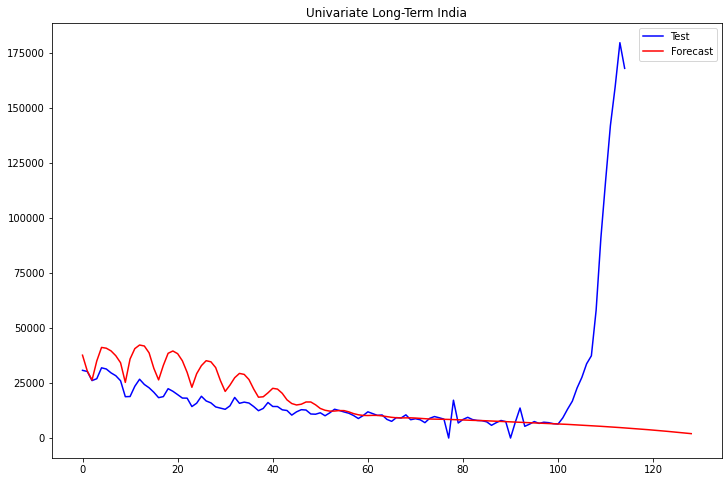

In [67]:
evaluate.plot_fore_test(india_uni_test_np_denorm[timesteps:], yhat_uni_india_denorm, 'Univariate Long-Term India')

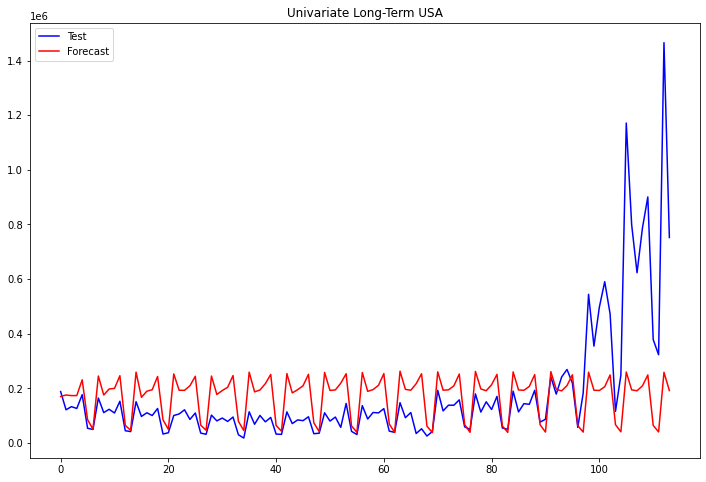

In [68]:
evaluate.plot_fore_test(usa_uni_test_np_denorm[timesteps:], yhat_uni_usa_denorm, 'Univariate Long-Term USA')

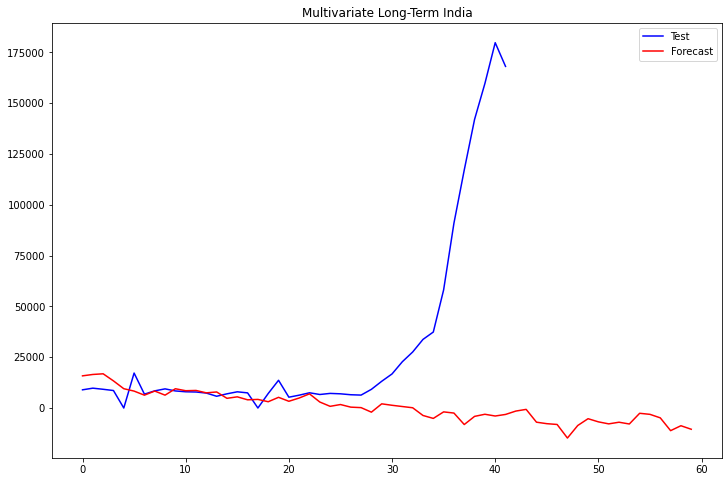

In [69]:
evaluate.plot_fore_test(india_multi_test_np_long_denorm[14:], yhat_multi_india_long_denorm[:60], "Multivariate Long-Term India")

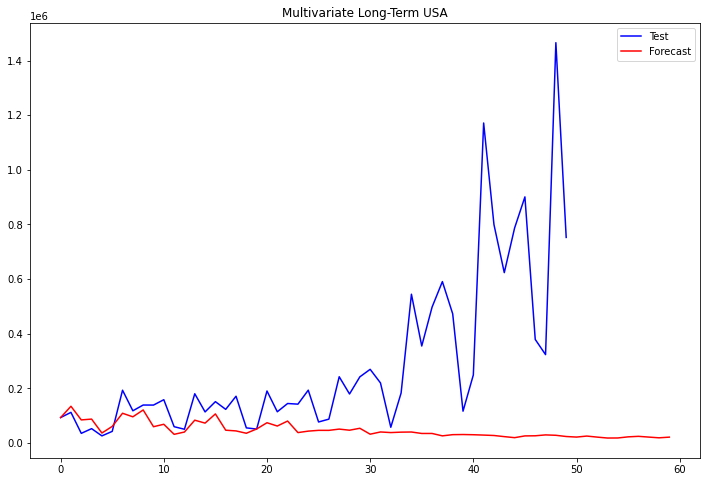

In [70]:
evaluate.plot_fore_test(usa_multi_test_np_long_denorm[14:], yhat_multi_usa_long_denorm[:60], "Multivariate Long-Term USA")

#### Short-Term Rolling Forecast

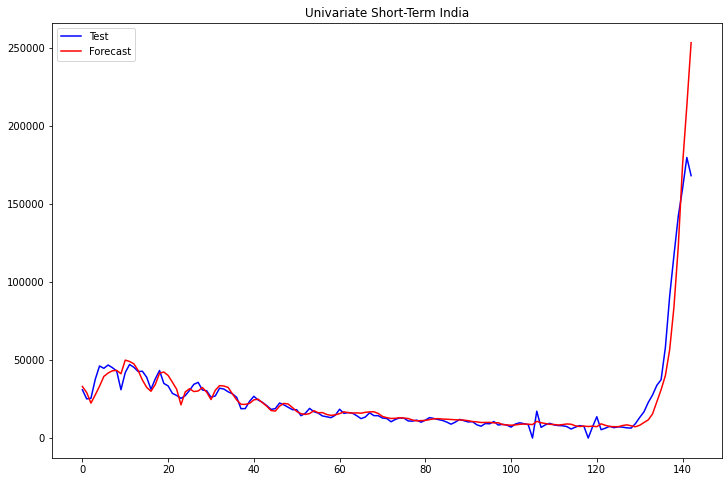

In [71]:
evaluate.plot_fore_test(india_uni_test_short_denorm, yhat_uni_india_short_denorm, "Univariate Short-Term India")

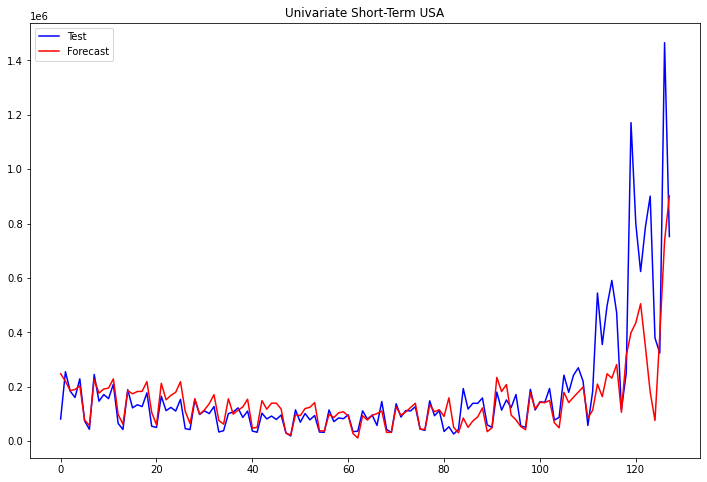

In [72]:
evaluate.plot_fore_test(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm, "Univariate Short-Term USA")

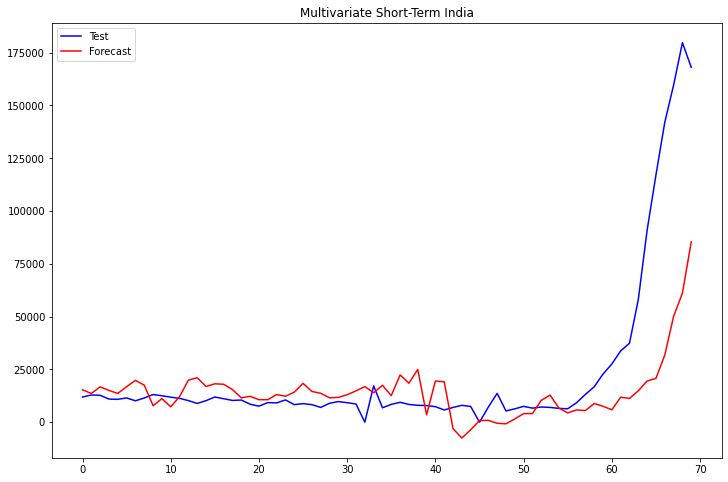

In [73]:
evaluate.plot_fore_test(india_multi_test_np_denorm, yhat_multi_india_denorm[0::2], "Multivariate Short-Term India")

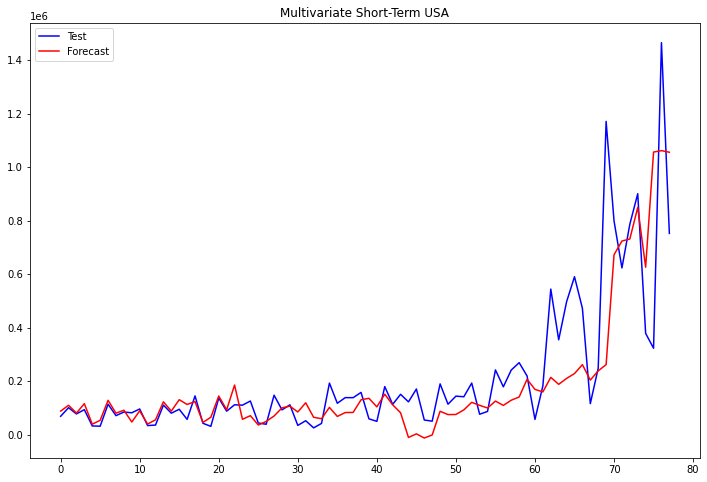

In [74]:
evaluate.plot_fore_test(usa_multi_test_np_denorm, yhat_multi_usa_denorm[0::2], "Multivariate Short-Term USA")